<a href="https://colab.research.google.com/github/khyun8072/AI_math_tutorial/blob/main/Week3/251021_%EA%B5%B0AI_%EC%8B%A4%EC%8A%B5%EC%9E%90%EB%A3%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EN→FR Translation: LSTM+Attention vs From-Scratch Transformer vs Fine-tuned T5

이 노트북은 **영어→프랑스어 기계번역**을 위한 세 가지 딥러닝 접근법을 비교합니다.

## 다루는 내용

### 데이터셋
- **Dataset:** `Helsinki-NLP/opus-100` (영–프랑스 병렬 말뭉치)
- 고품질 병렬 번역 데이터로 약 100만 쌍의 영어-프랑스어 문장 포함

### 비교 모델
- **Model A (LSTM+Attention)**:
  - Seq2Seq 아키텍처 기반 LSTM 인코더-디코더
  - Bahdanau Attention 메커니즘으로 긴 문장 처리 개선
  - 전통적이지만 효과적인 RNN 기반 번역 모델
  
- **Model B (From-scratch Transformer)**:
  - 무작위 초기화된 소형 Transformer (BERT tokenizer 사용)
  - 완전히 새롭게 학습하는 인코더-디코더 구조
  - Self-attention으로 병렬 처리와 장거리 의존성 포착
  
- **Model C (Pretrained T5 fine-tuning)**:
  - `t5-small`을 영→프 번역 태스크에 미세조정
  - 대규모 사전학습의 이점 활용
  - Text-to-Text 프레임워크로 태스크 통일

### 평가 & 해석
- **평가 지표**: `sacreBLEU` - 표준 기계번역 평가 메트릭
- **시각화**: **Attention Map**으로 각 모델의 내부 동작 비교
- **질적 분석**: 동일 문장에 대한 세 모델의 번역 품질 비교

## 학습 목표
1. RNN 기반(LSTM)과 Transformer 기반 아키텍처의 차이 이해
2. 사전학습 모델과 From-scratch 학습의 성능 차이 체험
3. Attention 메커니즘의 작동 원리를 시각화로 직관적 이해
4. 각 접근법의 장단점과 실무 적용 시나리오 파악

## 0) 환경 설정

필요한 라이브러리를 설치합니다. 이 셀은 Colab 또는 새로운 환경에서 처음 실행할 때만 필요합니다.

### 설치되는 패키지:
- `transformers`: Hugging Face의 사전학습 모델 및 토크나이저
- `datasets`: 데이터셋 로드 및 전처리
- `accelerate`: 학습 가속화 도구
- `evaluate`: 평가 메트릭 라이브러리
- `sacrebleu`: BLEU 점수 계산
- `sentencepiece`: T5 토크나이저용 서브워드 분할
- `matplotlib`: 시각화
- `torch`: PyTorch 딥러닝 프레임워크

In [ ]:
!pip -q install evaluate sacrebleu sentencepiece --upgrade

## 1) 라이브러리 임포트 & 시드 설정

이 섹션에서는 필요한 모든 라이브러리를 임포트하고 재현성을 위한 랜덤 시드를 설정합니다.

### 재현성(Reproducibility)의 중요성:
- 동일한 시드를 사용하면 매번 같은 결과를 얻을 수 있습니다
- 실험 결과를 비교하고 디버깅할 때 필수적입니다
- Python, NumPy, PyTorch의 모든 난수 생성기를 고정합니다

In [ ]:
import os, math, random, torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict

from datasets import load_dataset, DatasetDict
import evaluate
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq, Trainer, TrainingArguments,
    EncoderDecoderModel, BertConfig
)

# 재현성을 위한 모든 랜덤 시드 고정
SEED = 42
random.seed(SEED)  # Python 랜덤 시드
np.random.seed(SEED)  # NumPy 랜덤 시드
torch.manual_seed(SEED)  # PyTorch CPU 랜덤 시드
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)  # PyTorch GPU 랜덤 시드
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # 사용할 GPU 설정
os.environ["HF_HUB_ENABLE_XET"] = "0"
# GPU 사용 가능 여부 확인 및 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

## 2) 데이터셋 로드 (`Helsinki-NLP/opus-100`, EN→FR)

### OPUS-100 데이터셋이란?
- **OPUS**는 공개 병렬 말뭉치(Open Parallel Corpus) 프로젝트입니다
- **100개 언어 쌍**을 포함하는 대규모 다국어 번역 데이터셋
- 영어-프랑스어(EN-FR) 쌍은 고품질 번역 데이터로 구성

### 데이터 구조:
- `train`: 학습용 데이터 (약 100만 문장 쌍)
- `validation`: 검증용 데이터 (모델 성능 모니터링)
- `test`: 최종 평가용 데이터

In [ ]:
# 언어 쌍 설정: 영어(en) → 프랑스어(fr)
lang_pair = ("en", "fr")

# Hugging Face Hub에서 OPUS-100 데이터셋 다운로드
# 첫 실행 시 자동으로 다운로드되며, 이후에는 캐시된 데이터 사용
dataset = load_dataset("Helsinki-NLP/opus-100", "en-fr")

# 데이터 크기 확인
dataset

### 빠른 실습을 위한 서브셋

전체 데이터셋은 학습 시간이 오래 걸리므로, 빠른 실험을 위해 서브셋을 사용합니다.

**서브셋 크기:**
- 학습(train): 10,000 문장 쌍
- 검증(validation): 1,000 문장 쌍  
- 테스트(test): 1,000 문장 쌍

**참고:** 실제 프로덕션 모델 학습 시에는 `USE_SUBSET = False`로 설정하여 전체 데이터를 사용하세요.

In [ ]:
# 서브셋 사용 여부 설정
USE_SUBSET = True
TRAIN_SAMPLES = 2_0000  # 학습 데이터 개수
VAL_SAMPLES   = 1_000   # 검증 데이터 개수
TEST_SAMPLES  = 1_000   # 테스트 데이터 개수

def take_subset(ds, n):
    """
    데이터셋에서 처음 n개의 샘플만 추출하는 함수

    Args:
        ds: Hugging Face Dataset 객체
        n: 추출할 샘플 개수

    Returns:
        n개의 샘플로 이루어진 새로운 Dataset 객체
    """
    return ds.select(range(min(n, len(ds))))

# 서브셋 생성 또는 전체 데이터셋 사용
if USE_SUBSET:
    dataset_small = DatasetDict({
        "train": take_subset(dataset["train"], TRAIN_SAMPLES),
        "validation": take_subset(dataset["validation"], VAL_SAMPLES),
        "test": take_subset(dataset["test"], TEST_SAMPLES),
    })
else:
    dataset_small = dataset

# 각 split의 크기 출력
print("Dataset splits:", {k: len(v) for k, v in dataset_small.items()})
dataset_small

## 3) 토크나이저 설정

토크나이저는 텍스트를 모델이 이해할 수 있는 숫자(토큰 ID)로 변환하는 역할을 합니다.

### 왜 서로 다른 토크나이저를 사용하나요?

각 모델은 서로 다른 토크나이제이션 방식으로 사전학습되었기 때문에, 해당 모델에 맞는 토크나이저를 사용해야 합니다.

**1. BERT Multilingual Tokenizer (LSTM + From-scratch Transformer용)**
- WordPiece 기반 서브워드 분할
- 다국어 지원 (영어, 프랑스어 모두 처리 가능)
- 어휘 크기: 약 119,547개

**2. T5 Tokenizer (Fine-tuned T5용)**
- SentencePiece 기반 서브워드 분할
- Task prefix 지원 ("translate English to French: ")
- 어휘 크기: 32,128개

In [ ]:
# ==================== BERT Multilingual 토크나이저 설정 ====================
# LSTM + From-scratch Transformer에서 사용
tok_name = "google-bert/bert-base-multilingual-cased"
tokenizer_bert = AutoTokenizer.from_pretrained(tok_name)

# 특수 토큰 ID 저장 (패딩, 문장 시작/끝 등을 나타내는 특별한 토큰)
PAD_ID = tokenizer_bert.pad_token_id  # 패딩 토큰: 배치 내 문장 길이를 맞추기 위해 사용
UNK_ID = tokenizer_bert.unk_token_id  # 미등록 토큰: 어휘에 없는 단어
CLS_ID = tokenizer_bert.cls_token_id  # 문장 시작 토큰
SEP_ID = tokenizer_bert.sep_token_id  # 문장 끝 토큰
VOCAB_SIZE = tokenizer_bert.vocab_size  # 전체 어휘 크기

max_length_bert = 128  # BERT 토크나이저의 최대 시퀀스 길이

# ==================== T5 토크나이저 설정 ====================
# Fine-tuned T5 모델에서 사용
model_name_t5 = "google/flan-t5-small"
tokenizer_t5 = AutoTokenizer.from_pretrained(model_name_t5)

# T5는 task prefix를 사용하여 어떤 작업을 수행할지 모델에게 알려줌
task_prefix = "translate English to French: "

max_source_length = 128  # 입력 문장의 최대 길이
max_target_length = 128  # 출력 문장의 최대 길이

# 토크나이저 정보 출력
print("BERT Tokenizer:", tok_name, "| Vocab size:", VOCAB_SIZE)
print("T5 Tokenizer:", model_name_t5, "| Vocab size:", tokenizer_t5.vocab_size)

## 4) 평가 지표: sacreBLEU

### BLEU (Bilingual Evaluation Understudy)란?
- 기계번역의 품질을 자동으로 평가하는 표준 메트릭
- 기계번역 결과와 사람이 번역한 참조 번역을 비교
- n-gram 중복도를 기반으로 0-100점 사이의 점수 계산

### sacreBLEU
- BLEU의 표준화된 구현체
- 재현 가능하고 일관된 평가를 보장
- 논문에서 보고하는 점수와 비교 가능

In [ ]:
# sacreBLEU 메트릭 로드
bleu = evaluate.load("sacrebleu")
def postprocess_text(preds, labels):
    """
    예측 결과와 레이블 텍스트의 후처리를 수행하는 함수

    역할:
    - BLEU 계산을 위해 텍스트 형식을 맞춰줌
    - 예측값: 리스트 형태로 유지
    - 레이블: 이중 리스트로 변환 (BLEU는 여러 참조 번역을 지원하기 때문)

    Args:
        preds: 예측된 번역 텍스트 리스트
        labels: 정답 번역 텍스트 리스트

    Returns:
        전처리된 (preds, labels) 튜플
    """
    # 앞뒤 공백 제거
    preds = [pred.strip() for pred in preds]
    # BLEU는 여러 참조 번역을 지원하므로 각 레이블을 리스트로 감싸줌
    labels = [[label.strip()] for label in labels]
    return preds, labels

def compute_metrics_t5(eval_pred):
    """
    T5 모델의 평가 메트릭을 계산하는 함수

    역할:
    - Trainer가 검증 단계에서 자동으로 호출
    - 토큰 ID를 텍스트로 디코딩
    - sacreBLEU 점수 계산

    Args:
        eval_pred: (predictions, labels) 튜플

    Returns:
        {"sacrebleu": score} 딕셔너리
    """
    preds, labels = eval_pred
    # 튜플 형태로 반환되는 경우 첫 번째 요소만 사용
    if isinstance(preds, tuple):
        preds = preds[0]

    # ✅ logits을 토큰 ID로 변환 (가장 높은 확률의 토큰 선택)
    preds = np.argmax(preds, axis=-1)

    # 토큰 ID를 텍스트로 변환
    decoded_preds = tokenizer_t5.batch_decode(preds, skip_special_tokens=True)

    # -100은 loss 계산에서 무시되는 토큰이므로 pad_token_id로 대체
    labels = np.where(labels != -100, labels, tokenizer_t5.pad_token_id)
    decoded_labels = tokenizer_t5.batch_decode(labels, skip_special_tokens=True)

    # 후처리 및 BLEU 점수 계산
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    return {"sacrebleu": result["score"]}

def compute_metrics_bert(eval_pred):
    """
    BERT 기반 모델의 평가 메트릭을 계산하는 함수

    역할:
    - From-scratch Transformer 모델 평가에 사용
    - T5와 동일한 방식이지만 BERT 토크나이저 사용

    Args:
        eval_pred: (predictions, labels) 튜플

    Returns:
        {"sacrebleu": score} 딕셔너리
    """
    preds, labels = eval_pred
    if isinstance(preds, tuple):
        preds = preds[0]

    # BERT 토크나이저로 디코딩
    decoded_preds = tokenizer_bert.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer_bert.pad_token_id)
    decoded_labels = tokenizer_bert.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    return {"sacrebleu": result["score"]}

---
## 5) Model A: LSTM Seq2Seq with Attention

### Attention 메커니즘 한눈에 보기

**Attention**은 디코더가 인코더의 어떤 토큰에 집중해야 하는지 학습으로 결정하게 해 주는 가중치 테이블입니다.

#### 핵심 개념:
1. **컨텍스트 벡터**: 각 디코딩 스텝마다 소프트맥스를 통해 중요도가 계산되며, 그 결과로 컨텍스트 벡터가 만들어집니다.
2. **장문 처리**: LSTM과 결합하면 길이가 긴 문장에서도 중요한 단어를 잊지 않고 번역 품질을 끌어올릴 수 있습니다.
3. **해석 가능성**: 시각화된 히트맵은 어느 소스 토큰이 대응되는지 직관적으로 보여 줍니다.

#### Attention의 동작 방식 (3단계):

**1단계: Attention Scores 계산**
- **Query (Q)**: 디코더의 현재 hidden state - "지금 생성할 단어는 무엇인가?"
- **Keys (K)**: 인코더의 모든 hidden states - "소스 문장의 각 단어 정보"
- **Scores**: Query와 각 Key 간의 유사도 계산 (dot product)
  - `score(i) = Query · Key(i)` (스케일링 적용)

**2단계: Attention Distribution 생성**
- **Attention Weights (α)**: Scores에 softmax를 적용하여 확률 분포로 변환
  - `α(i) = softmax(scores) = exp(score(i)) / Σ exp(score(j))`
  - 모든 가중치의 합은 1.0 (확률 분포)
  - 높은 가중치 = 해당 소스 단어에 더 집중

**3단계: Attention Output 생성**
- **Values (V)**: 인코더의 모든 hidden states (Keys와 동일)
- **Context Vector**: Attention Weights와 Values의 가중합
  - `context = Σ α(i) × Value(i)`
  - 중요한 소스 단어들의 정보가 강조된 벡터
  - 이 벡터가 디코더의 입력으로 사용되어 다음 단어 예측에 활용됨

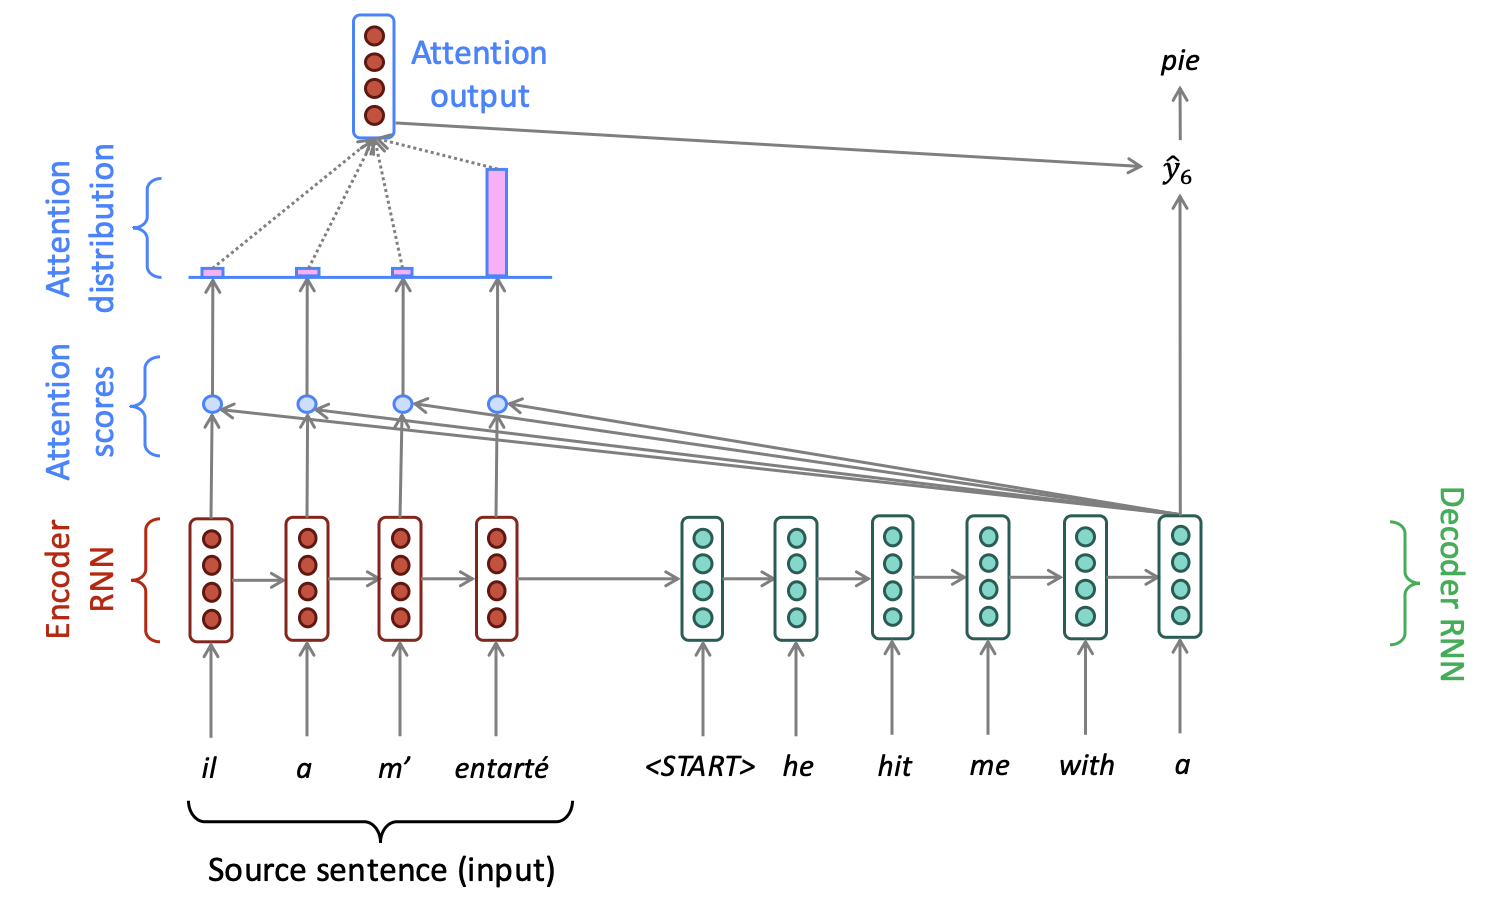

In [ ]:
class Encoder(nn.Module):
    """
    LSTM 기반 인코더

    역할:
    - 입력 문장(소스 언어)을 임베딩 벡터로 변환
    - LSTM을 통해 시퀀스를 인코딩하여 hidden states 생성
    - 각 타임스텝의 출력과 최종 hidden/cell state 반환
    """
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        # 단어 ID를 dense vector로 변환하는 임베딩 레이어
        self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_ID)
        # 양방향이 아닌 단방향 LSTM (Seq2Seq에서는 단방향 사용)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True,
                           dropout=dropout if num_layers>1 else 0.0)

    def forward(self, src):
        # src: [batch_size, src_len] → x: [batch_size, src_len, embed_dim]
        x = self.emb(src)
        # outputs: [batch_size, src_len, hidden_dim] - 각 타임스텝의 출력
        # h: [num_layers, batch_size, hidden_dim] - 최종 hidden state
        # c: [num_layers, batch_size, hidden_dim] - 최종 cell state
        outputs, (h, c) = self.rnn(x)
        return outputs, (h, c)

class Attention(nn.Module):
    """
    Bahdanau Attention 메커니즘

    역할:
    - 디코더의 현재 상태와 인코더의 모든 출력 간의 유사도 계산
    - 소프트맥스로 attention weights 생성
    - 가중합으로 context vector 생성
    """
    def __init__(self, hidden_dim):
        super().__init__()
        # Scaled dot-product attention을 위한 스케일 팩터
        self.scale = 1.0 / math.sqrt(hidden_dim)

    def forward(self, dec_h, enc_out, src_mask=None):
        """
        Args:
            dec_h: 디코더의 현재 hidden state [batch, 1, hidden_dim]
            enc_out: 인코더의 모든 출력 [batch, src_len, hidden_dim]
            src_mask: 패딩 마스크 [batch, src_len]

        Returns:
            ctx: context vector [batch, 1, hidden_dim]
            attn: attention weights [batch, 1, src_len]
        """
        # 유사도 계산: [batch, 1, hidden] @ [batch, hidden, src_len] = [batch, 1, src_len]
        scores = torch.bmm(dec_h, enc_out.transpose(1,2)) * self.scale

        # 패딩 위치는 -inf로 마스킹 (softmax 후 0이 됨)
        if src_mask is not None:
            scores = scores.masked_fill(src_mask[:,None,:]==0, float('-inf'))

        # attention weights: softmax로 확률 분포로 변환
        attn = scores.softmax(dim=-1)

        # context vector: attention weights와 인코더 출력의 가중합
        ctx = torch.bmm(attn, enc_out)
        return ctx, attn

class AttnDecoder(nn.Module):
    """
    Attention 메커니즘을 갖춘 LSTM 디코더

    역할:
    - 이전 토큰과 context vector를 입력받아 다음 토큰 예측
    - Attention을 사용하여 소스 문장의 관련 부분에 집중
    """
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        # 타겟 단어 임베딩
        self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_ID)
        # LSTM 입력: 임베딩 + context vector
        self.rnn = nn.LSTM(embed_dim + hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True,
                           dropout=dropout if num_layers>1 else 0.0)
        # 최종 출력: hidden state → vocabulary 크기의 로짓
        self.fc  = nn.Linear(hidden_dim, vocab_size)
        self.drop = nn.Dropout(dropout)
        self.attn = Attention(hidden_dim)

    def forward(self, inp_tok, hidden, enc_out, src_mask=None):
        """
        Args:
            inp_tok: 현재 입력 토큰 [batch]
            hidden: 이전 스텝의 (h, c) 상태
            enc_out: 인코더 출력 [batch, src_len, hidden_dim]
            src_mask: 소스 마스크 [batch, src_len]

        Returns:
            logits: 다음 토큰 예측 [batch, vocab_size]
            hidden: 업데이트된 (h, c) 상태
            attn: attention weights [batch, 1, src_len]
        """
        # 토큰 임베딩: [batch] → [batch, 1, embed_dim]
        x = self.emb(inp_tok.unsqueeze(1))

        # 현재 hidden state 추출 (마지막 레이어)
        h_t = hidden[0][-1].unsqueeze(1)

        # Attention으로 context vector 계산
        ctx, attn = self.attn(h_t, enc_out, src_mask)

        # 임베딩과 context를 결합하여 LSTM 입력 생성
        rnn_in = torch.cat([x, ctx], dim=-1)

        # LSTM 업데이트
        out, hidden = self.rnn(rnn_in, hidden)

        # 다음 토큰 로짓 예측
        logits = self.fc(out.squeeze(1))
        return logits, hidden, attn

class Seq2SeqAttn(nn.Module):
    """
    Encoder-Decoder with Attention 전체 모델

    역할:
    - 인코더로 소스 문장 인코딩
    - 디코더로 타겟 문장 생성 (autoregressive)
    - Teacher forcing을 사용한 학습
    """
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def make_src_mask(self, src):
        """패딩이 아닌 토큰에 대해 True를 반환하는 마스크 생성"""
        return (src != PAD_ID).to(src.device)

    def forward(self, src, trg, teacher_forcing=0.5, return_attn=False):
        """
        Args:
            src: 소스 문장 [batch, src_len]
            trg: 타겟 문장 [batch, trg_len]
            teacher_forcing: teacher forcing 비율 (0.0~1.0)
            return_attn: attention weights 반환 여부

        Returns:
            logits: 각 타임스텝의 예측 [batch, trg_len-1, vocab_size]
            (optional) attn: attention weights
        """
        B, Ttrg = trg.size()

        # 1. 인코더로 소스 문장 인코딩
        enc_out, hidden = self.encoder(src)
        src_mask = self.make_src_mask(src)

        # 2. 디코더 초기 입력 (첫 번째 토큰은 보통 [CLS])
        inp = trg[:,0]

        logits_list, attn_list = [], []

        # 3. 타겟 문장을 한 토큰씩 생성
        for t in range(1, Ttrg):
            # 현재 토큰 예측
            logits, hidden, attn = self.decoder(inp, hidden, enc_out, src_mask)
            logits_list.append(logits.unsqueeze(1))
            attn_list.append(attn)

            # Teacher forcing: 정답 토큰 vs 예측 토큰
            use_tf = (random.random() < teacher_forcing)
            next_tok = trg[:,t] if use_tf else logits.argmax(-1)
            inp = next_tok

        # 모든 타임스텝의 예측을 결합
        logits = torch.cat(logits_list, dim=1)

        if return_attn:
            at = torch.cat(attn_list, dim=1).squeeze(2)
            return logits, at
        return logits

In [ ]:
# Cross Entropy Loss 정의 (패딩 토큰은 무시)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)


def shift_trg_for_loss(trg):
    """
    타겟 시퀀스를 한 칸 왼쪽으로 시프트하여 loss 계산용으로 변환

    역할:
    - 디코더는 t번째 토큰을 입력받아 t+1번째 토큰을 예측
    - 따라서 정답 레이블은 1번째부터 끝까지 (첫 번째 토큰은 제외)

    Args:
        trg: [batch, trg_len] 타겟 시퀀스

    Returns:
        [batch, trg_len-1] 시프트된 시퀀스
    """
    return trg[:, 1:].contiguous()


def train_one_epoch(model, dl, opt, teacher_forcing, clip=1.0, verbose=True):
    """
    LSTM + Attention 모델의 1 에폭 학습 함수

    역할:
    - 전체 학습 데이터를 한 번 순회하며 모델 파라미터 업데이트
    - Teacher forcing을 사용하여 학습 안정화
    - Gradient clipping으로 gradient exploding 방지

    Args:
        model: Seq2SeqAttn 모델
        dl: 학습 데이터로더
        opt: Optimizer
        teacher_forcing: Teacher forcing 비율 (0.0 ~ 1.0)
        clip: Gradient clipping 임계값
        verbose: 중간 loss 출력 여부

    Returns:
        평균 loss 값
    """
    model.train()
    total, n = 0.0, 0

    for i, (src, trg) in enumerate(dl):
        # 데이터를 GPU로 이동
        src, trg = src.to(device), trg.to(device)

        # Gradient 초기화
        opt.zero_grad()

        # Forward pass (teacher forcing 사용)
        out = model(src, trg, teacher_forcing=teacher_forcing)

        # 타겟 시프트 (예측과 정답을 맞추기 위해)
        tgt = shift_trg_for_loss(trg)

        # Loss 계산
        # out: [batch, trg_len-1, vocab_size] → flatten to [batch*(trg_len-1), vocab_size]
        # tgt: [batch, trg_len-1] → flatten to [batch*(trg_len-1)]
        loss = criterion(out.reshape(-1, out.size(-1)), tgt.reshape(-1))

        # Backward pass
        loss.backward()

        # Gradient clipping (gradient exploding 방지)
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        opt.step()

        # Loss 누적
        total += loss.item()
        n += 1

        # 중간 loss 출력 (매 50 배치마다)
        if verbose and (i + 1) % 50 == 0:
            print(f"  Batch {i+1}/{len(dl)}: loss={total/n:.4f}")

    return total / n


@torch.no_grad()
def eval_model(model, dl):
    """
    LSTM + Attention 모델의 검증 함수

    역할:
    - Teacher forcing 없이 검증 데이터에서 loss 계산
    - Gradient 계산 비활성화로 메모리 절약

    Args:
        model: Seq2SeqAttn 모델
        dl: 검증 데이터로더

    Returns:
        평균 loss 값
    """
    model.eval()
    total, n = 0.0, 0

    for src, trg in dl:
        src, trg = src.to(device), trg.to(device)

        # Teacher forcing 없이 예측 (검증 시에는 실제 추론과 동일하게)
        out = model(src, trg, teacher_forcing=0.0)

        tgt = shift_trg_for_loss(trg)
        loss = criterion(out.reshape(-1, out.size(-1)), tgt.reshape(-1))

        total += loss.item()
        n += 1

    return total / n

In [ ]:
# ==================== LSTM 데이터 전처리 ====================

def encode_text_bert(s: str, max_len=128):
    """
    BERT 토크나이저로 텍스트를 토큰 ID로 변환

    역할:
    - 텍스트를 WordPiece 토큰으로 분할
    - 특수 토큰([CLS], [SEP]) 자동 추가
    - 최대 길이로 잘라내기(truncation)

    Args:
        s: 입력 텍스트
        max_len: 최대 시퀀스 길이

    Returns:
        토큰 ID 리스트
    """
    return tokenizer_bert(
        s,
        add_special_tokens=True,  # [CLS]와 [SEP] 토큰 추가
        max_length=max_len + 2,   # 특수 토큰을 위한 공간 확보
        truncation=True,
        padding=False,  # 배치 단위로 패딩하므로 여기서는 안 함
        return_tensors=None,
    )["input_ids"]

In [ ]:
def preprocess_function_bert(batch):
    """Tokenizer-based preprocessing for the from-scratch Transformer."""
    src_texts = [x[lang_pair[0]] for x in batch["translation"]]
    tgt_texts = [x[lang_pair[1]] for x in batch["translation"]]

    model_inputs = tokenizer_bert(
        src_texts,
        max_length=max_length_bert,
        padding="max_length",
        truncation=True,
    )

    with tokenizer_bert.as_target_tokenizer():
        labels = tokenizer_bert(
            tgt_texts,
            max_length=max_length_bert,
            padding="max_length",
            truncation=True,
        )["input_ids"]

    labels = [
        [(lid if lid != tokenizer_bert.pad_token_id else -100) for lid in label]
        for label in labels
    ]
    model_inputs["labels"] = labels
    return model_inputs


def preprocess_bert_dataset(dataset_dict):
    """Map the BERT preprocessing across the dataset before training."""
    ds = dataset_dict if hasattr(dataset_dict, "map") else DatasetDict(dataset_dict)
    return ds.map(
        preprocess_function_bert,
        batched=True,
        remove_columns=ds["train"].column_names,
    )


### LSTM 데이터셋 및 DataLoader 준비

LSTM 모델은 커스텀 데이터셋과 collate 함수가 필요합니다.

In [ ]:
class EnDeDataset(Dataset):
    """
    영어-프랑스어 번역 데이터셋 (LSTM용)

    역할:
    - Hugging Face Dataset을 PyTorch Dataset으로 변환
    - 각 샘플을 토크나이즈하여 텐서로 반환
    """
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        """
        Returns:
            src_ids: 소스 문장의 토큰 ID 텐서
            trg_ids: 타겟 문장의 토큰 ID 텐서
        """
        tr = self.pairs[idx]["translation"]
        src_ids = torch.tensor(encode_text_bert(tr["en"]), dtype=torch.long)
        trg_ids = torch.tensor(encode_text_bert(tr["fr"]), dtype=torch.long)
        return src_ids, trg_ids


def collate(batch):
    """
    가변 길이 시퀀스를 배치로 묶는 collate 함수

    역할:
    - 배치 내에서 가장 긴 시퀀스에 맞춰 패딩 추가
    - PyTorch의 pad_sequence 사용

    Args:
        batch: [(src_ids, trg_ids), ...] 리스트

    Returns:
        srcs_pad: 패딩된 소스 배치 [batch, max_src_len]
        trgs_pad: 패딩된 타겟 배치 [batch, max_trg_len]
    """
    srcs, trgs = zip(*batch)
    srcs_pad = pad_sequence(srcs, batch_first=True, padding_value=PAD_ID)
    trgs_pad = pad_sequence(trgs, batch_first=True, padding_value=PAD_ID)
    return srcs_pad, trgs_pad


def prepare_lstm_dataloaders(dataset_dict, batch_size=16):
    """
    LSTM 모델용 데이터로더 생성

    역할:
    - Dataset 객체 생성
    - DataLoader로 배치 단위 이터레이터 생성

    Args:
        dataset_dict: Hugging Face DatasetDict
        batch_size: 배치 크기

    Returns:
        train_dl, valid_dl: 학습 및 검증 데이터로더
    """
    ds = dataset_dict if hasattr(dataset_dict, "items") else DatasetDict(dataset_dict)
    train_ds = EnDeDataset(ds["train"])
    valid_ds = EnDeDataset(ds["validation"])
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, collate_fn=collate)
    return train_dl, valid_dl


BATCH_SIZE = 16

# LSTM용 데이터로더 생성
train_dl_lstm, valid_dl_lstm = prepare_lstm_dataloaders(dataset_small, batch_size=BATCH_SIZE)
print('LSTM용 데이터로더 전처리가 완료되었습니다.')

In [ ]:
sample_pair = dataset_small['train'][0]['translation']
print('원문 EN:', sample_pair['en'])
print('정답 FR:', sample_pair['fr'])

encoded_ids = encode_text_bert(sample_pair['en'])
print('토큰 ID 예시 (앞 12개):', encoded_ids[:12])
print('총 토큰 수:', len(encoded_ids))

tmp_train_dl, tmp_valid_dl = prepare_lstm_dataloaders(dataset_small, batch_size=2)
batch_src, batch_trg = next(iter(tmp_train_dl))
print('배치 텐서 크기:', batch_src.shape, batch_trg.shape)

### LSTM 모델 학습 실행

In [ ]:
# ==================== LSTM 모델 초기화 및 학습 ====================

# 하이퍼파라미터 설정
EMBED_DIM = 256      # 임베딩 차원
HIDDEN_DIM = 512     # LSTM hidden state 차원
NUM_LAYERS = 1       # LSTM 레이어 개수
DROPOUT = 0.1        # Dropout 비율
LR = 5e-3            # Learning rate
EPOCHS = 3           # 학습 에폭 수
CLIP = 1.0           # Gradient clipping 임계값
TEACHER_FORCING = 1.0  # Teacher forcing 비율 (1.0 = 100% 정답 사용)

# 체크포인트 저장 디렉토리
SAVE_DIR = "./checkpoints_enfr"
os.makedirs(SAVE_DIR, exist_ok=True)

# 모델 생성
enc = Encoder(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
dec = AttnDecoder(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
model_attn = Seq2SeqAttn(enc, dec).to(device)

# Optimizer: AdamW (Adam + Weight Decay)
opt_attn = torch.optim.AdamW(model_attn.parameters(), lr=LR)


In [ ]:

print(f"[Model A: LSTM+Attention] Total params: {sum(p.numel() for p in model_attn.parameters()):,}")
print("=" * 80)

# 학습 루프
best_val = 1e9
attn_ckpt = os.path.join(SAVE_DIR, "seq2seq_attn.pt")

for ep in range(1, EPOCHS + 1):
    print(f"\n[LSTM+Attn] Epoch {ep}/{EPOCHS}")

    # 학습
    tr = train_one_epoch(model_attn, train_dl_lstm, opt_attn, TEACHER_FORCING, CLIP, verbose=True)

    # 검증
    va = eval_model(model_attn, valid_dl_lstm)

    # Best 모델 저장
    if va < best_val:
        best_val = va
        torch.save(model_attn.state_dict(), attn_ckpt)
        print(f"  Best model saved! train={tr:.4f}  valid={va:.4f}")
    else:
        print(f"  train={tr:.4f}  valid={va:.4f}")

print(f"\n{'=' * 80}")
print(f"LSTM+Attention 학습 완료! Best valid loss: {best_val:.4f}")
print(f"Saved: {attn_ckpt}")

In [ ]:
@torch.no_grad()
def translate_attn(model, text: str, max_new_tokens=60, collect_attn=True):
    """
    LSTM+Attention 모델로 번역 수행

    역할:
    - 영어 문장을 프랑스어로 번역
    - Autoregressive 방식으로 한 토큰씩 생성
    - Attention weights 수집하여 시각화 가능

    Args:
        model: Seq2SeqAttn 모델
        text: 입력 영어 문장
        max_new_tokens: 생성할 최대 토큰 수
        collect_attn: Attention weights 수집 여부

    Returns:
        text_out: 생성된 프랑스어 번역
        attn_mat: Attention 가중치 행렬 [trg_len, src_len]
        src: 소스 토큰 ID 배열
    """
    model.eval()

    # 소스 문장 토크나이즈
    src = torch.tensor(encode_text_bert(text), dtype=torch.long).unsqueeze(0).to(device)

    # 인코더로 소스 인코딩
    enc_out, hidden = model.encoder(src)
    src_mask = (src != PAD_ID)

    # 디코더 초기 입력 ([CLS] 토큰)
    inp = torch.tensor([CLS_ID], device=device)

    pred_ids, steps = [], []

    # 토큰 하나씩 생성
    for _ in range(max_new_tokens):
        logits, hidden, attn = model.decoder(inp, hidden, enc_out, src_mask)

        # 가장 높은 확률의 토큰 선택 (greedy decoding)
        nxt = int(logits.argmax(-1).item())

        # [SEP] 토큰이 나오면 종료
        if nxt == SEP_ID:
            break

        pred_ids.append(nxt)

        # Attention weights 수집
        if collect_attn:
            steps.append(attn.squeeze(0).squeeze(0).detach().cpu().numpy())

        # 다음 스텝의 입력으로 사용
        inp = torch.tensor([nxt], device=device)

    # 토큰 ID를 텍스트로 디코딩
    text_out = tokenizer_bert.decode(pred_ids, skip_special_tokens=True)

    # Attention 행렬 생성
    attn_mat = np.stack(steps, axis=0) if (collect_attn and len(steps) > 0) else None

    return text_out, attn_mat, src.squeeze(0).cpu().numpy()


def tokens_from_ids(ids, tokenizer):
    """
    토큰 ID를 토큰 문자열로 변환 (특수 토큰 제외)

    역할:
    - 시각화를 위해 토큰 ID를 읽기 쉬운 문자열로 변환
    - [CLS], [SEP], [PAD] 등 특수 토큰은 제외

    Args:
        ids: 토큰 ID 배열
        tokenizer: 토크나이저 객체

    Returns:
        필터링된 토큰 리스트
    """
    toks = tokenizer.convert_ids_to_tokens(ids)
    return [t for t in toks if t not in (tokenizer.cls_token, tokenizer.sep_token,
                                         tokenizer.pad_token, tokenizer.unk_token)]


def plot_attention_lstm(src_tokens, trg_tokens, attn, title="LSTM Attention Heatmap"):
    """
    LSTM Attention 가중치를 히트맵으로 시각화

    역할:
    - 각 타겟 토큰이 어떤 소스 토큰에 집중하는지 시각화
    - x축: 소스 문장 토큰
    - y축: 타겟 문장 토큰
    - 색상: Attention 가중치 (밝을수록 높은 가중치)

    Args:
        src_tokens: 소스 토큰 리스트
        trg_tokens: 타겟 토큰 리스트
        attn: Attention 가중치 행렬 [trg_len, src_len]
        title: 그래프 제목
    """
    plt.figure(figsize=(min(12, 0.5 * len(src_tokens) + 3), min(10, 0.5 * len(trg_tokens) + 3)))
    plt.imshow(attn[:len(trg_tokens), :len(src_tokens)], aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.yticks(range(len(trg_tokens)), trg_tokens, fontsize=10)
    plt.xticks(range(len(src_tokens)), src_tokens, rotation=45, ha='right', fontsize=9)
    plt.xlabel('Source (EN) [WordPiece]')
    plt.ylabel('Target (FR) [WordPiece]')
    plt.title(title)
    plt.tight_layout()
    plt.show()

### LSTM+Attention 예시 번역 및 Attention Map 시각화

In [ ]:
# 테스트 문장

test_sent = dataset_small['test'][2]['translation']['en']
test_sent_ft = dataset_small['test'][2]['translation']['fr']

# ==================== Model A: 저장된 모델 로드 ====================
# attn_ckpt = "./checkpoints_enfr/seq2seq_attn.pt"
if os.path.exists(attn_ckpt):
    model_attn.load_state_dict(torch.load(attn_ckpt, map_location=device))
    print(f"✓ LSTM Attention 모델 로드됨: {attn_ckpt}\n")
else:
    print(f"⚠️  체크포인트를 찾을 수 없습니다: {attn_ckpt}")
    print("   학습을 먼저 실행하세요 (Cell 24)\n")

print("="*80)
print("[Model A: LSTM+Attention] 예시 번역")
print("="*80)
print(f"EN: {test_sent}")
print(f"FR: {test_sent_ft}")

fr_out, attn_weights, src_ids = translate_attn(model_attn, test_sent, collect_attn=True)
print(f"Predict FR: {fr_out}")

if attn_weights is not None:
    src_toks = tokens_from_ids(src_ids, tokenizer_bert)
    trg_toks = tokenizer_bert.tokenize(fr_out)
    plot_attention_lstm(src_toks, trg_toks, attn_weights, title="Model A: LSTM+Attention Heatmap")

---
## 6) Model B: From-Scratch Transformer (Encoder-Decoder)

### Self-Attention과 Transformer 핵심 아이디어
Transformer의 셀프 어텐션은 문장 내부 모든 위치 쌍을 동시에 살피면서 관계를 학습합니다.
- Query, Key, Value 행렬을 통해 토큰 간 연관도를 계산하고, 멀티헤드 구조로 다양한 표현을 병렬로 추출합니다.
- 위치 정보를 더하기 위해 포지셔널 인코딩을 사용하며, RNN 대비 훨씬 깊고 길게 학습하기 수월합니다.
- 인코더-디코더 구조에서는 인코더의 self-attention과 디코더의 self-attention, 그리고 cross-attention이 협력하여 번역을 완성합니다.

### Transformers

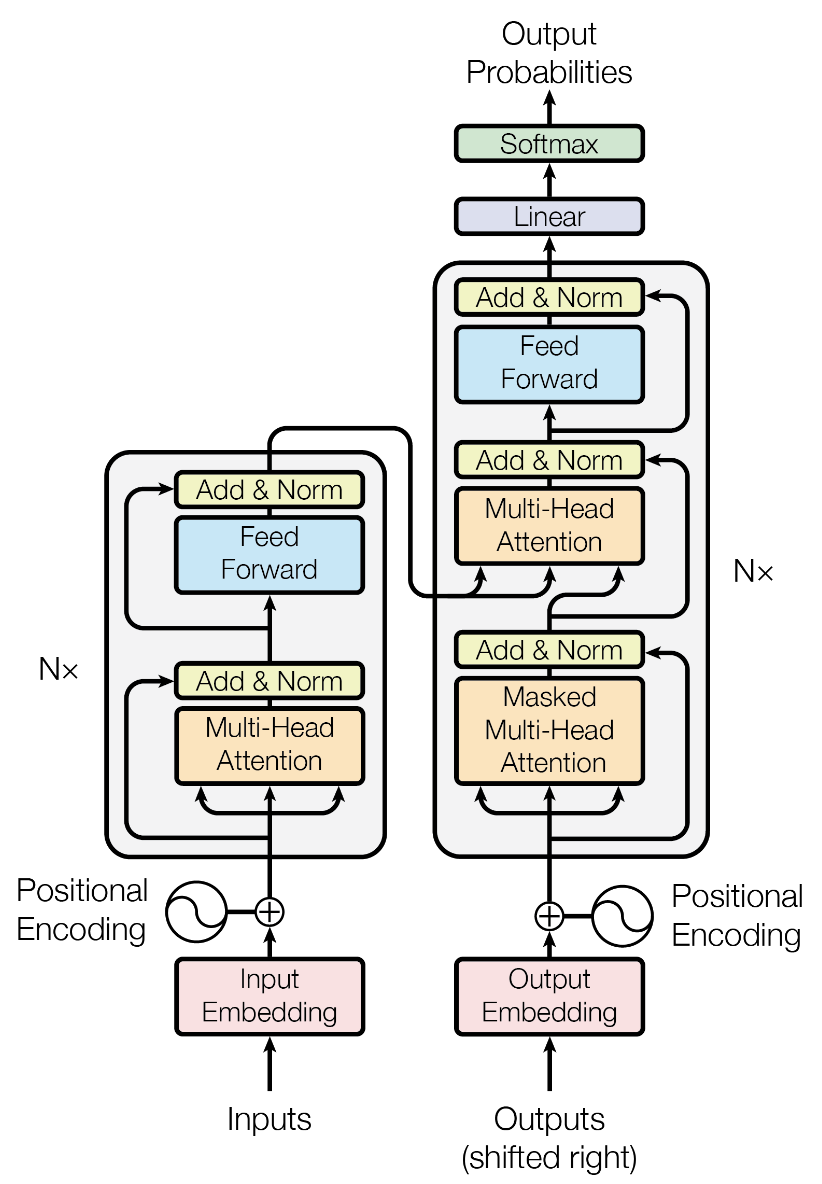

In [ ]:
# ==================== From-Scratch Transformer 모델 정의 ====================

import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    """위치 인코딩: Transformer에 시퀀스 순서 정보 제공"""
    def __init__(self, d_model, max_len=512, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 위치 인코딩 생성
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """x: (batch_size, seq_len, d_model)"""
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class DecoderLayerWithXAttn(nn.TransformerDecoderLayer):
    """
    nn.TransformerDecoderLayer를 확장해서 cross-attention 가중치를 선택적으로 반환
    반환 형태: attn (batch, num_heads, tgt_len, src_len)
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(
        self, tgt, memory, tgt_mask=None, memory_mask=None,
        tgt_key_padding_mask=None, memory_key_padding_mask=None,
        need_weights: bool = False,
        average_attn_weights: bool = False,
    ):
        # 1) self-attention (가중치는 필요없음)
        x = tgt
        x2, _ = self.self_attn(
            x, x, x,
            attn_mask=tgt_mask,
            key_padding_mask=tgt_key_padding_mask,
            need_weights=False
        )
        x = x + self.dropout1(x2)
        x = self.norm1(x)

        # 2) cross-attention (여기서 가중치 받기)
        x2, xattn = self.multihead_attn(
            x, memory, memory,
            attn_mask=memory_mask,
            key_padding_mask=memory_key_padding_mask,
            need_weights=need_weights,
            average_attn_weights=average_attn_weights  # False면 헤드별 가중치
        )
        x = x + self.dropout2(x2)
        x = self.norm2(x)

        # 3) FFN
        x2 = self.linear2(self.dropout(self.activation(self.linear1(x))))
        x = x + self.dropout3(x2)
        x = self.norm3(x)

        # 반환
        if need_weights:
            if xattn is not None and xattn.dim() == 2:
                xattn = xattn.unsqueeze(0).unsqueeze(0)  # (1,1,T,S)
            return x, xattn
        return x, None


class TransformerDecoderWithXAttn(nn.Module):
    """
    디코더 스택을 돌리며 레이어별 cross-attention 가중치를 수집
    """
    def __init__(self, decoder_layer: nn.Module, num_layers: int):
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(decoder_layer) for _ in range(num_layers)])
        self.num_layers = num_layers

    def forward(
        self, tgt, memory, tgt_mask=None, memory_mask=None,
        tgt_key_padding_mask=None, memory_key_padding_mask=None,
        need_weights: bool = False,
        average_attn_weights: bool = False,
    ):
        x = tgt
        xattn_all = []  # 각 레이어의 (B, H, T, S)
        for layer in self.layers:
            x, xattn = layer(
                x, memory,
                tgt_mask=tgt_mask,
                memory_mask=memory_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask,
                need_weights=need_weights,
                average_attn_weights=average_attn_weights
            )
            if need_weights:
                xattn_all.append(xattn)
        return x, xattn_all if need_weights else None


class TransformerSeq2Seq(nn.Module):
    """PyTorch Transformer 기반 Seq2Seq 모델 (cross-attn 가중치 수집 지원)"""
    def __init__(self, vocab_size, d_model=256, nhead=4, num_encoder_layers=4,
                 num_decoder_layers=4, dim_feedforward=512, dropout=0.1, max_len=512):
        super().__init__()

        self.d_model = d_model
        self.vocab_size = vocab_size
        self.nhead = nhead

        # 임베딩 레이어
        self.src_embedding = nn.Embedding(vocab_size, d_model, padding_idx=PAD_ID)
        self.tgt_embedding = nn.Embedding(vocab_size, d_model, padding_idx=PAD_ID)

        # 위치 인코딩
        self.pos_encoder = PositionalEncoding(d_model, max_len, dropout)

        # Transformer 인코더
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)

        # Transformer 디코더 (확장 버전)
        decoder_layer = DecoderLayerWithXAttn(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = TransformerDecoderWithXAttn(decoder_layer, num_decoder_layers)

        # 출력 레이어
        self.fc_out = nn.Linear(d_model, vocab_size)

        # 가중치 초기화
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def make_src_mask(self, src):
        return (src == PAD_ID)  # (batch, src_len)

    def make_tgt_mask(self, tgt):
        batch_size, tgt_len = tgt.size()
        tgt_mask = torch.triu(torch.ones(tgt_len, tgt_len, device=tgt.device), diagonal=1).bool()
        tgt_padding_mask = (tgt == PAD_ID)
        return tgt_mask, tgt_padding_mask

    def forward(self, src, tgt, *, need_xattn: bool = False, per_head: bool = True):
        """
        Returns:
            logits: (batch, tgt_len, vocab_size)
            xattn_all: Optional[List[(batch, num_heads, tgt_len, src_len)]]
        """
        src_padding_mask = self.make_src_mask(src)
        tgt_mask, tgt_padding_mask = self.make_tgt_mask(tgt)

        # 임베딩 + 위치 인코딩
        src_emb = self.pos_encoder(self.src_embedding(src) * math.sqrt(self.d_model))
        tgt_emb = self.pos_encoder(self.tgt_embedding(tgt) * math.sqrt(self.d_model))

        # 인코더
        memory = self.transformer_encoder(src_emb, src_key_padding_mask=src_padding_mask)

        # 디코더 (가중치 수집 on/off)
        dec_out, xattn_all = self.transformer_decoder(
            tgt_emb,
            memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=src_padding_mask,
            need_weights=need_xattn,
            average_attn_weights=(not per_head)  # False면 (B,H,T,S)
        )

        # 출력
        logits = self.fc_out(dec_out)
        return (logits, xattn_all) if need_xattn else (logits, None)


# 모델 초기화 예시 (나중에 실제 학습 시 사용)
model_scratch = TransformerSeq2Seq(
    vocab_size=len(tokenizer_bert),
    d_model=256,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=512,
    dropout=0.1
).to(device)


### From-Scratch Transformer 데이터 전처리 및 학습

Transformer는 Hugging Face Trainer를 사용하므로 데이터셋 전처리가 필요합니다.

In [ ]:
# ==================== From-Scratch Transformer 학습 ====================

# Transformer용 학습 함수
def train_transformer_epoch(model, dataloader, optimizer, clip=1.0):
    """Transformer 모델 1 epoch 학습"""
    model.train()
    epoch_loss = 0

    for batch in dataloader:
        src = batch[0].to(device)  # (batch_size, src_len)
        tgt = batch[1].to(device)  # (batch_size, tgt_len)

        # Teacher forcing: 디코더 입력은 타겟의 [:-1] (마지막 토큰 제외)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]  # 예측해야 할 타겟 (첫 토큰 제외)

        optimizer.zero_grad()

        # Forward
        output, _ = model(src, tgt_input, need_xattn=False)  # (batch_size, tgt_len-1, vocab_size)

        # Loss 계산
        output = output.reshape(-1, output.shape[-1])  # (batch_size * tgt_len, vocab_size)
        tgt_output = tgt_output.reshape(-1)  # (batch_size * tgt_len)

        loss = nn.CrossEntropyLoss(ignore_index=PAD_ID)(output, tgt_output)

        # Backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

def eval_transformer(model, dataloader):
    """Transformer 모델 검증"""
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            src = batch[0].to(device)
            tgt = batch[1].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output, _ = model(src, tgt_input, need_xattn=False)

            output = output.reshape(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)

            loss = nn.CrossEntropyLoss(ignore_index=PAD_ID)(output, tgt_output)
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

# 데이터로더 준비 (LSTM과 동일한 데이터 사용 가능)
train_dl_transformer, valid_dl_transformer = prepare_lstm_dataloaders(dataset_small, batch_size=32)

# 옵티마이저 설정
optimizer_scratch = torch.optim.Adam(model_scratch.parameters(), lr=3e-4)


In [ ]:

# 학습 설정
EPOCHS_TRANSFORMER = 5
CLIP = 1.0

# 체크포인트 디렉토리
scratch_ckpt_dir = "./checkpoints_enfr/from_scratch_transformer"
os.makedirs(scratch_ckpt_dir, exist_ok=True)
scratch_ckpt_path = os.path.join(scratch_ckpt_dir, "model.pt")

print(f"\n{'='*60}")
print(f"From-Scratch Transformer 학습 시작")
print(f"{'='*60}")

best_valid_loss = float('inf')

for epoch in range(1, EPOCHS_TRANSFORMER + 1):
    print(f"\n[Epoch {epoch}/{EPOCHS_TRANSFORMER}]")

    # 학습
    train_loss = train_transformer_epoch(model_scratch, train_dl_transformer, optimizer_scratch, CLIP)

    # 검증
    valid_loss = eval_transformer(model_scratch, valid_dl_transformer)

    print(f"  Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")

    # Best 모델 저장
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_scratch.state_dict(), scratch_ckpt_path)
        print(f"  ✓ Best 모델 저장: {scratch_ckpt_path}")

print(f"\n{'='*60}")
print(f"From-Scratch Transformer 학습 완료!")
print(f"Best Validation Loss: {best_valid_loss:.4f}")
print(f"{'='*60}")


### From-Scratch Transformer 번역 함수

In [ ]:
@torch.no_grad()
def translate_transformer_scratch(model, text: str, max_new_tokens=64, return_attention=False, debug=False):
    """
    From-Scratch Transformer로 번역 수행 (Greedy Decoding)

    Args:
        model: TransformerSeq2Seq 모델
        text: 입력 영어 문장
        max_new_tokens: 생성할 최대 토큰 수
        return_attention: Attention weights 반환 여부
        debug: 디버깅 정보 출력 여부

    Returns:
        translation: 번역된 텍스트
        (선택) attention_weights: Cross-attention weights (if return_attention=True)
    """
    model.eval()

    # 입력 텍스트 토크나이즈
    src_ids = encode_text_bert(text)
    src = torch.LongTensor([src_ids]).to(device)  # (1, src_len)

    # 디코더 시작: [CLS] 토큰
    tgt_ids = [CLS_ID]

    # Autoregressive 생성
    for step in range(max_new_tokens):
        tgt = torch.LongTensor([tgt_ids]).to(device)  # (1, tgt_len)

        # 예측 (attention은 마지막 forward에서만 가져오면 됨)
        output, _ = model(src, tgt, need_xattn=False)  # (1, tgt_len, vocab_size)

        # 마지막 토큰의 예측 확률
        next_token_logits = output[0, -1, :]  # (vocab_size,)
        next_token_id = next_token_logits.argmax().item()

        # 종료 조건: [SEP] 토큰 생성
        if next_token_id == SEP_ID:

            break

        tgt_ids.append(next_token_id)

    # 디코딩
    translation = tokenizer_bert.decode(tgt_ids, skip_special_tokens=True)

    if return_attention:
        # 최종 생성된 문장으로 한 번 더 forward pass해서 attention 추출
        tgt_final = torch.LongTensor([tgt_ids]).to(device)
        _, xattn_all = model(src, tgt_final, need_xattn=True, per_head=True)

        # xattn_all: List[(batch, num_heads, tgt_len, src_len)]
        # 마지막 레이어의 attention 반환
        return translation, xattn_all, src_ids, tgt_ids

    return translation


# 간단한 테스트
test_sentence = "Hello, how are you?"
print(f"\n테스트 번역:")
print(f"  EN: {test_sentence}")
try:
    translation = translate_transformer_scratch(model_scratch, test_sentence)
    print(f"  FR: {translation}")
except Exception as e:
    print(f"  오류: {e}")
    print("  (학습 후 정상 작동합니다)")


In [ ]:
def plot_cross_attention_transformer(model, text: str, average_layers=True, layer=0, head=0):
    """
    From-Scratch Transformer의 Cross-attention 시각화

    역할:
    - Transformer 디코더의 cross-attention 가중치를 히트맵으로 표시
    - BERT WordPiece 토큰 단위로 시각화

    Args:
        model: TransformerSeq2Seq 모델
        text: 입력 텍스트
        average_layers: True면 모든 레이어 평균, False면 특정 레이어만
        layer: average_layers=False일 때 시각화할 디코더 레이어 인덱스
        head: 시각화할 attention head 인덱스
    """
    # Attention과 함께 번역 생성
    translation, xattn_all, src_ids, tgt_ids = translate_transformer_scratch(
        model, text, return_attention=True
    )

    if xattn_all is None or len(xattn_all) == 0:
        print("⚠️  Attention weights를 가져올 수 없습니다.")
        return

    # xattn_all: List[(batch, num_heads, tgt_len, src_len)]
    if average_layers:
        # 모든 레이어의 평균
        layer_attentions = []
        for layer_attn in xattn_all:
            if layer_attn is not None:
                # (batch, num_heads, tgt_len, src_len) -> (tgt_len, src_len) for specific head
                layer_attentions.append(layer_attn[0, head].detach().cpu().numpy())

        if len(layer_attentions) == 0:
            print("⚠️  유효한 레이어 attention이 없습니다.")
            return

        # 레이어들의 평균
        attn_head = np.mean(layer_attentions, axis=0)
        title_suffix = f"All Layers Averaged, Head {head}"
    else:
        # 특정 레이어만
        if layer >= len(xattn_all):
            print(f"⚠️  Layer {layer}는 존재하지 않습니다. 총 {len(xattn_all)}개 레이어.")
            return

        layer_attn = xattn_all[layer]
        if layer_attn is None:
            print(f"⚠️  Layer {layer}의 attention이 None입니다.")
            return

        attn = layer_attn[0].detach().cpu().numpy()  # (num_heads, tgt_len, src_len)

        if head >= attn.shape[0]:
            print(f"⚠️  Head {head}는 존재하지 않습니다. 총 {attn.shape[0]}개 헤드.")
            return

        attn_head = attn[head]  # (tgt_len, src_len)
        title_suffix = f"Layer {layer}, Head {head}"

    # 토큰 변환
    src_tokens = tokenizer_bert.convert_ids_to_tokens(src_ids)
    tgt_tokens = tokenizer_bert.convert_ids_to_tokens(tgt_ids)

    # 히트맵 시각화
    import matplotlib.pyplot as plt

    plt.figure(figsize=(min(14, 0.6 * len(src_tokens) + 3), min(12, 0.6 * len(tgt_tokens) + 3)))
    plt.imshow(attn_head, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Attention Weight')

    # 축 레이블
    plt.yticks(range(len(tgt_tokens)), tgt_tokens, fontsize=10)
    plt.xticks(range(len(src_tokens)), src_tokens, rotation=45, ha='right', fontsize=9)

    plt.xlabel('Source (EN) [BERT WordPiece]', fontsize=11)
    plt.ylabel('Target (FR) [BERT WordPiece]', fontsize=11)
    plt.title(f"Model B: From-Scratch Transformer Cross-Attention\n{title_suffix}", fontsize=12)
    plt.tight_layout()
    plt.show()

    print(f"\n번역 결과:")
    print(f"  EN: {text}")
    print(f"  FR: {translation}")

### From-Scratch Transformer 예시 번역 및 Attention Map 시각화

In [ ]:
# ==================== Model B: 저장된 모델 로드 ====================
scratch_ckpt_path = "./checkpoints_enfr/from_scratch_transformer/model.pt"
if os.path.exists(scratch_ckpt_path):
    model_scratch.load_state_dict(torch.load(scratch_ckpt_path, map_location=device))
    print(f"✓ From-Scratch Transformer 모델 로드됨: {scratch_ckpt_path}\n")
else:
    print(f"⚠️  체크포인트를 찾을 수 없습니다: {scratch_ckpt_path}\n")

print("="*80)
print("[Model B: From-Scratch Transformer] 예시 번역")
print("="*80)
print(f"EN: {test_sent}")
print(f"FR: {test_sent_ft}")

fr_out_scratch = translate_transformer_scratch(model_scratch, test_sent, debug=True)
# Debug mode enabled: 상세한 토큰 생성 과정을 볼 수 있습니다
print(f"Predict FR: {fr_out_scratch}")

# Cross-attention 시각화 - 모든 레이어 평균으로 표시
plot_cross_attention_transformer(model_scratch, test_sent, average_layers=True, head=0)

In [ ]:
import gc

gc.collect()                 # 파이썬 객체 메모리 정리
torch.cuda.empty_cache()     # CUDA 캐시 비우기
torch.cuda.ipc_collect()     # 공유 메모리 핸들 정리 (optional)


---
## 7) Model C: Pretrained `t5-small` 미세조정

### T5 모델 개요
T5(Text-to-Text Transfer Transformer)는 모든 NLP 문제를 텍스트 입력과 텍스트 출력의 형태로 통일한 모델입니다.
- 거대한 사전학습(Colossal Clean Crawled Corpus)으로 다수의 언어 작업을 학습했으며, 프롬프트(prefix)를 달리해 태스크를 구분합니다.
- 미세조정 시에는 프리픽스를 붙여 문제를 설명하고, 동일한 모델 구조로 번역/요약/문제해결 등 다양한 작업을 수행할 수 있습니다.
- 본 노트북에서는 `t5-small` 체크포인트를 불러와 EN→FR 번역 태스크에 맞춰 추가 학습합니다.

In [ ]:
@torch.no_grad()
def translate_t5(model, texts, max_new_tokens=64, num_beams=4, output_attentions=False):
    """
    Fine-tuned T5 모델로 번역 수행

    역할:
    - Task prefix를 포함하여 T5 형식에 맞게 입력 구성
    - Beam search로 다양한 번역 후보 탐색 후 최선 선택

    Args:
        model: T5ForConditionalGeneration 모델
        texts: 입력 텍스트 리스트
        max_new_tokens: 생성할 최대 토큰 수
        num_beams: Beam search beam 개수 (attention 시각화 시 1 권장)
        output_attentions: Attention weights 반환 여부

    Returns:
        번역 텍스트 리스트 (또는 텍스트와 생성 출력 튜플)
    """
    model.eval()

    # Task prefix 추가
    inputs = tokenizer_t5([task_prefix + t for t in texts], return_tensors="pt", padding=True).to(device)

    if output_attentions:
        # Attention을 얻기 위해서는 greedy decoding 사용 (num_beams=1)
        gen = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=1,  # Attention 추출 시 beam=1
            output_attentions=True,
            return_dict_in_generate=True
        )
        return tokenizer_t5.batch_decode(gen.sequences, skip_special_tokens=True), gen
    else:
        # 일반 번역 시 beam search 사용
        gen = model.generate(**inputs, max_new_tokens=max_new_tokens, num_beams=num_beams)
        return tokenizer_t5.batch_decode(gen, skip_special_tokens=True)


def plot_cross_attention_t5(model, text: str, average_layers=True, layer=0, head=0):
    """
    T5 모델의 Cross-attention 시각화

    역할:
    - T5 디코더의 cross-attention 가중치를 히트맵으로 표시
    - SentencePiece 토큰 단위로 시각화

    Args:
        model: T5ForConditionalGeneration 모델
        text: 입력 텍스트
        average_layers: True면 모든 레이어 평균, False면 특정 레이어만
        layer: average_layers=False일 때 시각화할 디코더 레이어 인덱스
        head: 시각화할 attention head 인덱스
    """
    # Attention과 함께 번역 생성
    translations, gen_out = translate_t5(model, [text], output_attentions=True)

    if hasattr(gen_out, 'cross_attentions') and gen_out.cross_attentions:
        # cross_attentions: tuple of (num_layers, ) where each element is (batch, num_heads, tgt_len, src_len)
        # 각 디코딩 스텝마다 cross_attentions이 반환됨

        # 모든 디코딩 스텝의 cross-attention 수집
        all_step_attentions = []
        for step_idx, step_attentions in enumerate(gen_out.cross_attentions):  # 각 생성 스텝
            if average_layers:
                # 모든 레이어의 평균
                layer_attentions = []
                for layer_idx, layer_attn in enumerate(step_attentions):  # 각 레이어
                    # layer_attn: (batch, num_heads, tgt_len, src_len)
                    attn_array = layer_attn[0, head].detach().cpu().numpy()

                    # Debug: first step only
                    if step_idx == 0 and layer_idx == 0:
                        print(f"Original attention shape: {attn_array.shape}")

                    # Flatten to 1D vector (for single target token at this step)
                    # Shape should be (src_len,) or (1, src_len)
                    attn_array = attn_array.flatten()
                    layer_attentions.append(attn_array)

                # 레이어들의 평균
                avg_attn = np.mean(layer_attentions, axis=0)
                all_step_attentions.append(avg_attn)
            else:
                # 특정 레이어만
                attn_array = step_attentions[layer][0, head].detach().cpu().numpy()
                # Flatten to 1D
                attn_array = attn_array.flatten()
                all_step_attentions.append(attn_array)

        # 모든 스텝을 하나의 행렬로 결합 (tgt_len, src_len)
        combined_attn = np.array(all_step_attentions)

        # Debug: print shape
        print(f"Combined attention shape: {combined_attn.shape}")

        # T5 토크나이저로 토큰 추출
        src_tokens = tokenizer_t5.tokenize(task_prefix + text)
        tgt_tokens = tokenizer_t5.tokenize(translations[0])

        print(f"Source tokens: {len(src_tokens)}, Target tokens: {len(tgt_tokens)}")

        # 생성된 토큰 수와 attention 매트릭스 크기 맞추기
        min_tgt_len = min(len(tgt_tokens), combined_attn.shape[0])
        min_src_len = min(len(src_tokens), combined_attn.shape[1])

        # 히트맵 시각화
        plt.figure(figsize=(min(12, 0.5 * min_src_len + 3), min(10, 0.5 * min_tgt_len + 3)))
        plt.imshow(combined_attn[:min_tgt_len, :min_src_len], aspect='auto', cmap='viridis')
        plt.colorbar()
        plt.yticks(range(min_tgt_len), tgt_tokens[:min_tgt_len], fontsize=10)
        plt.xticks(range(min_src_len), src_tokens[:min_src_len], rotation=45, ha='right', fontsize=9)
        plt.xlabel('Source (EN) [SentencePiece]')
        plt.ylabel('Target (FR) [SentencePiece]')

        if average_layers:
            plt.title(f"Model C: T5 Cross-Attention (All Layers Averaged, Head {head})")
        else:
            plt.title(f"Model C: T5 Cross-Attention (Layer {layer}, Head {head})")
        plt.tight_layout()
        plt.show()
    else:
        print('Cross-attention이 반환되지 않았습니다.')

### T5 번역 함수

In [ ]:
@torch.no_grad()
def translate_t5_fixed(model, texts, max_new_tokens=64, num_beams=4, output_attentions=False):
    """
    Fine-tuned T5 모델로 번역 수행
    """
    model.eval()

    # Task prefix 추가
    inputs = tokenizer_t5([task_prefix + t for t in texts], return_tensors="pt", padding=True).to(device)

    if output_attentions:
        # Attention을 얻기 위해서는 greedy decoding 사용 (num_beams=1)
        gen = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=1,  # Attention 추출 시 beam=1
            output_attentions=True,
            return_dict_in_generate=True
        )
        return tokenizer_t5.batch_decode(gen.sequences, skip_special_tokens=True), gen
    else:
        # 일반 번역 시 beam search 사용
        gen = model.generate(**inputs, max_new_tokens=max_new_tokens, num_beams=num_beams)
        return tokenizer_t5.batch_decode(gen, skip_special_tokens=True)


def plot_cross_attention_t5_fixed(model, text: str, average_layers=True, layer=0, head=0):
    """
    T5 모델의 Cross-attention 시각화 (수정 버전)
    """
    # Attention과 함께 번역 생성
    translations, gen_out = translate_t5_fixed(model, [text], output_attentions=True)

    if hasattr(gen_out, 'cross_attentions') and gen_out.cross_attentions:
        # 모든 디코딩 스텝의 cross-attention 수집
        all_step_attentions = []

        for step_idx, step_attentions in enumerate(gen_out.cross_attentions):  # 각 생성 스텝
            if average_layers:
                # 모든 레이어의 평균
                layer_attentions = []
                for layer_attn in step_attentions:  # 각 레이어
                    # layer_attn shape: (batch, num_heads, tgt_len, src_len)
                    # [0, head]로 인덱싱: (tgt_len, src_len) - 이게 (1, src_len)일 수 있음
                    attn_vec = layer_attn[0, head].detach().cpu().numpy()

                    # (1, src_len) -> (src_len,) 또는 그대로 (src_len,)
                    if attn_vec.ndim == 2 and attn_vec.shape[0] == 1:
                        attn_vec = attn_vec.squeeze(0)  # (src_len,)
                    elif attn_vec.ndim == 1:
                        pass  # 이미 (src_len,) 형태
                    else:
                        # 예상치 못한 형태면 flatten
                        attn_vec = attn_vec.flatten()

                    layer_attentions.append(attn_vec)

                # 레이어들의 평균: (src_len,)
                avg_attn = np.mean(layer_attentions, axis=0)
                all_step_attentions.append(avg_attn)
            else:
                # 특정 레이어만
                attn_vec = step_attentions[layer][0, head].detach().cpu().numpy()

                # Shape 처리
                if attn_vec.ndim == 2 and attn_vec.shape[0] == 1:
                    attn_vec = attn_vec.squeeze(0)
                elif attn_vec.ndim == 1:
                    pass
                else:
                    attn_vec = attn_vec.flatten()

                all_step_attentions.append(attn_vec)

        # 모든 스텝을 하나의 행렬로 결합: (tgt_len, src_len)
        combined_attn = np.stack(all_step_attentions, axis=0)

        print(f"✓ Combined attention shape: {combined_attn.shape}")

        # T5 토크나이저로 토큰 추출
        src_tokens = tokenizer_t5.tokenize(task_prefix + text)
        tgt_tokens = tokenizer_t5.tokenize(translations[0])

        print(f"✓ Source tokens: {len(src_tokens)}, Target tokens: {len(tgt_tokens)}")

        # 생성된 토큰 수와 attention 매트릭스 크기 맞추기
        min_tgt_len = min(len(tgt_tokens), combined_attn.shape[0])
        min_src_len = min(len(src_tokens), combined_attn.shape[1])

        # 히트맵 시각화
        plt.figure(figsize=(min(12, 0.5 * min_src_len + 3), min(10, 0.5 * min_tgt_len + 3)))
        plt.imshow(combined_attn[:min_tgt_len, :min_src_len], aspect='auto', cmap='viridis')
        plt.colorbar()
        plt.yticks(range(min_tgt_len), tgt_tokens[:min_tgt_len], fontsize=10)
        plt.xticks(range(min_src_len), src_tokens[:min_src_len], rotation=45, ha='right', fontsize=9)
        plt.xlabel('Source (EN) [SentencePiece]')
        plt.ylabel('Target (FR) [SentencePiece]')

        if average_layers:
            plt.title(f"Model C: T5 Cross-Attention (All Layers Averaged, Head {head})")
        else:
            plt.title(f"Model C: T5 Cross-Attention (Layer {layer}, Head {head})")
        plt.tight_layout()
        plt.show()
    else:
        print('Cross-attention이 반환되지 않았습니다.')


### Fine-tuned T5 예시 번역 및 Attention Map 시각화

In [ ]:
# ==================== Model C: 저장된 모델 로드 ====================
ft_model_path = "./checkpoints_enfr/t5_finetuned"
if os.path.exists(ft_model_path):
    model_ft = AutoModelForSeq2SeqLM.from_pretrained(ft_model_path).to(device)
    print(f"✓ Fine-tuned T5 모델 로드됨: {ft_model_path}\n")
else:
    print(f"⚠️  체크포인트를 찾을 수 없습니다: {ft_model_path}\n")

print("="*80)
print("[Model C: Fine-tuned T5] 예시 번역")
print("="*80)
print(f"EN: {test_sent}")
print(f"FR: {test_sent_ft}")

fr_out_t5 = translate_t5(model_ft, [test_sent])
print(f"Predict FR: {fr_out_t5[0]}")

# Cross-attention 시각화 - 모든 레이어 평균으로 표시
plot_cross_attention_t5_fixed(model_ft, test_sent, average_layers=True, head=0)

---
## 8) 최종 비교: 세 모델의 번역 결과 비교

이 섹션에서는 저장된 모델을 불러와서 같은 예시 문장에 대해 세 모델의 번역 결과를 비교합니다.

### 비교 목적:
1. **번역 품질**: 어떤 모델이 더 자연스럽고 정확한 번역을 생성하는가?
2. **모델 특성**: 각 모델의 강점과 약점은 무엇인가?
3. **실용성**: 실제 응용에서 어떤 모델을 선택해야 하는가?

### 평가 관점:
- 문법적 정확성
- 어휘 선택의 적절성
- 문장 구조의 자연스러움
- 원문의 의미 보존

In [ ]:
# ==================== 참고: 모델 로드 ====================
#
# 각 모델은 해당 테스트 셀에서 개별적으로 로드됩니다:
# - Model A (LSTM+Attention): Cell 27에서 로드
# - Model B (From-Scratch Transformer): Cell 37에서 로드
# - Model C (Fine-tuned T5): Cell 45에서 로드
#
# 이렇게 하면 각 모델을 독립적으로 테스트할 수 있습니다.

# 아래는 이전에 사용하던 통합 로드 코드입니다 (현재는 사용 안 함):
"""
# LSTM + Attention 모델 로드
if os.path.exists(attn_ckpt):
    model_attn.load_state_dict(torch.load(attn_ckpt, map_location=device))
    print(f"✓ LSTM Attention 모델 로드됨: {attn_ckpt}")

# From-Scratch Transformer 모델 로드
scratch_ckpt_path = "./checkpoints_enfr/from_scratch_transformer/model.pt"
if os.path.exists(scratch_ckpt_path):
    model_scratch.load_state_dict(torch.load(scratch_ckpt_path, map_location=device))
    print(f"✓ From-Scratch Transformer 모델 로드됨: {scratch_ckpt_path}")

# Fine-tuned T5 모델 로드
ft_model_path = "./checkpoints_enfr/t5_finetuned"
if os.path.exists(ft_model_path):
    model_ft = AutoModelForSeq2SeqLM.from_pretrained(ft_model_path).to(device)
    print(f"✓ Fine-tuned T5 모델 로드됨: {ft_model_path}")
"""

print("각 모델은 해당 테스트 셀에서 개별적으로 로드됩니다.")

In [ ]:
# 테스트 데이터셋에서 비교할 문장들 가져오기 (다양한 난이도와 길이)
# 인덱스 선택: 다양한 문장 길이와 복잡도를 가진 샘플
test_indices = [1, 50, 150]  # 원하는 테스트 샘플 인덱스

comparison_examples = []
for idx in test_indices:
    test_sample = dataset_small['test'][idx]
    comparison_examples.append({
        'en': test_sample['translation']['en'],
        'fr_reference': test_sample['translation']['fr']
    })

print("\n" + "="*100)
print("최종 비교: LSTM+Attention vs From-Scratch Transformer vs Fine-tuned T5")
print("="*100)

# 각 문장에 대해 세 모델의 번역 비교
for i, example in enumerate(comparison_examples):
    sent_en = example['en']
    sent_fr_ref = example['fr_reference']

    print(f"\n{'='*100}")
    print(f"EN (원문):     {sent_en}")
    print(f"FR (정답):     {sent_fr_ref}")
    # print(f"FR (예측):", end="")
    print("-"*100)

    # Model A: LSTM + Attention
    attn_out, _, _ = translate_attn(model_attn, sent_en, collect_attn=False)
    print(f"FR [Model A: LSTM+Attention]:      {attn_out}")

    # Model B: From-scratch Transformer
    scratch_out = translate_transformer_scratch(model_scratch, sent_en)
    print(f"FR [Model B: From-Scratch Trans]:  {scratch_out}")

    # Model C: Fine-tuned T5
    ft_out = translate_t5(model_ft, [sent_en])
    print(f"FR [Model C: Fine-tuned T5]:       {ft_out[0]}")

    print("="*100)
